In [1]:
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import six

%matplotlib inline


import flotilla
sns.set(style='ticks', context='paper')

folder = 'figures'

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects/'
study = flotilla.embark('singlecell_pnm', flotilla_dir=flotilla_dir)

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:55: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-05-13 08:29:02	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm/datapackage.json
2016-05-13 08:29:02	Parsing datapackage to create a Study object
2016-05-13 08:29:26	Initializing Study
2016-05-13 08:29:26	Initializing Predictor configuration manager for Study
2016-05-13 08:29:26	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-05-13 08:29:26	Added ExtraTreesClassifier to default predictors
2016-05-13 08:29:26	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-05-13 08:29:26	Added ExtraTreesRegressor to default predictors
2016-05-13 08:29:26	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-05-13 08:29:26	Added GradientBoostingClassifier to default predictors
2016-05-13 08:29:26	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.G

In [10]:
study.splicing.minimum_samples

10

In [2]:
mkdir $folder

mkdir: cannot create directory `figures': File exists


## Predict outliers of celltype using $k$-means outliers

In [6]:
%%time
from sklearn.cluster import KMeans

#
expression_singles = study.expression.singles.dropna(axis=0, how='all')

# run k-means clustering
km = KMeans(init='k-means++', n_clusters=3, n_init=1000, random_state=0)
km.fit(expression_singles)


CPU times: user 19min 58s, sys: 9min 51s, total: 29min 50s
Wall time: 4min 14s


### Determine group membership

In [7]:
from collections import defaultdict

# determine group membership
 
km_membership = dict(zip(expression_singles.index, km.labels_))
 
km_groups = defaultdict(list)
for sample in km_membership:
    km_groups[km_membership[sample]].append(study.sample_id_to_phenotype[sample])
    
# determine group outliers based on majority membership of cell type
km_outliers = []
 
km_colors = []
group_to_color = {}
for label in km_groups:
    lst = km_groups[label]
    most_common =  max(set(lst), key=lst.count)
    for sample in km_membership:
        sample_phenotype = study.sample_id_to_phenotype[sample]
        if sample_phenotype != most_common and km_membership[sample] == label:
            km_outliers.append(sample)

for x in sorted(km_outliers):
    six.print_(x)

M1_03
M1_04
M2_01
M2_02
M2_06
M2_07
M3_01
M3_03
M4_13
M6_02
N1_06
N1_09
N2_06
N4_10
P2_06


Remove the outliers

In [8]:
study.metadata.data['outlier'] = study.metadata.data.index.isin(km_outliers)
study.drop_outliers()

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects/'

study.save('singlecell_pnm_figure1_post_kmeans_outliers', flotilla_dir)

Wrote datapackage to /projects/ps-yeolab/obotvinnik/flotilla_projects//singlecell_pnm_figure1_post_kmeans_outliers/datapackage.json


Visually look at the outliers on PCA

/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:178: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  self.magnitudes.sort(ascending=False)
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:185: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  x.sort(ascending=True)
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:514: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  components = components.sort(columns='pc_1', ascending=False)


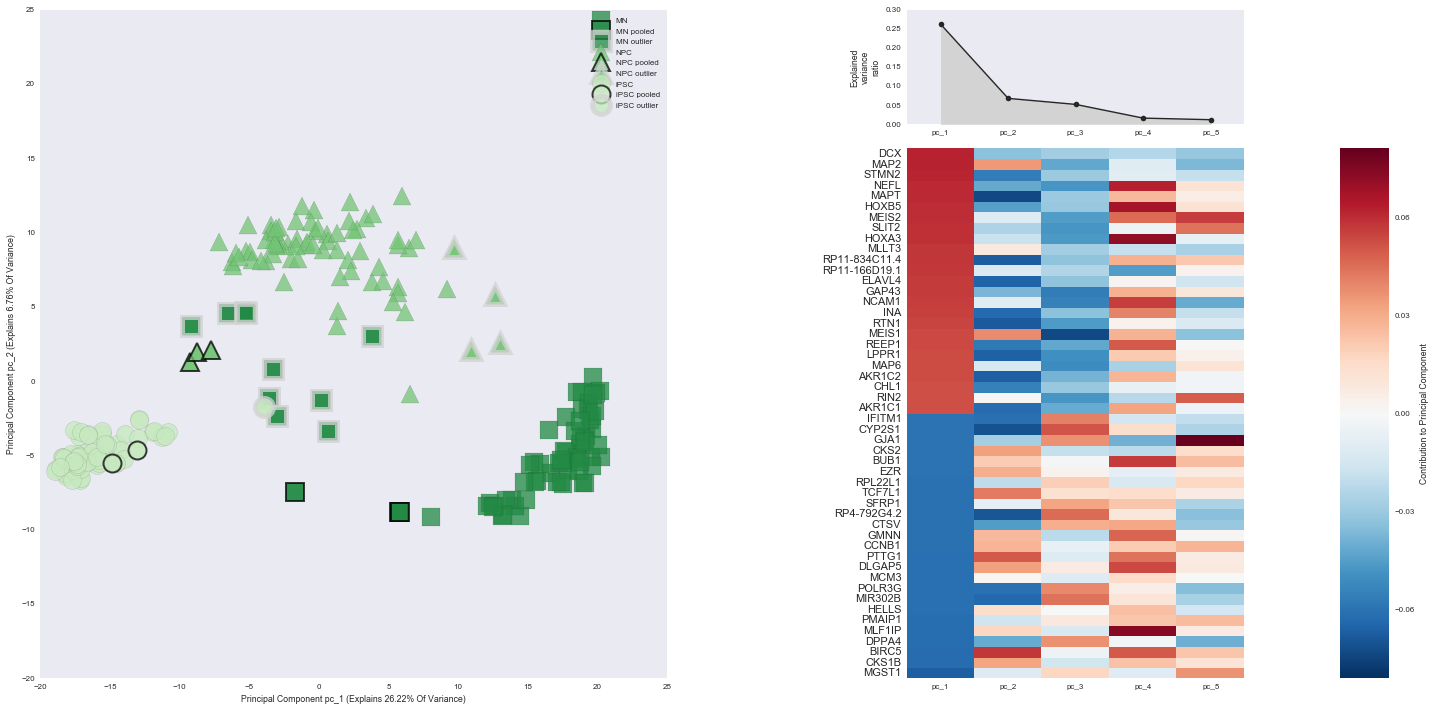

In [9]:
with sns.axes_style('dark'):
    viz = study.plot_pca(show_vectors=False, scale_by_variance=False, markersize=18)
    xmin, xmax, ymin, ymax = viz.ax_components.axis()
    vmin = min(xmin, ymin)
    vmax = max(xmax, ymax)
    viz.ax_components.set(xlim=(vmin, vmax), ylim=(vmin, vmax))
    viz.fig_reduced.savefig('{}/expression_pca.pdf'.format(folder))